## Regression

This regression process aims to predict flight arrival delays in minutes by leveraging various machine learning models. The analysis begins with preprocessing the dataset to ensure compatibility with regression algorithms.

Baseline models, such as Linear Regression and Elastic Net, are implemented to establish initial benchmarks. Advanced models, including Random Forest, XGBoost, and LightGBM, are optimized using grid search to enhance predictive performance.

Metrics such as MAE, RMSE, and R² are computed to evaluate model performance, and feature importance is analyzed to uncover key contributors to delays. The results demonstrate the strengths and limitations of each model, guiding the selection of the most effective approach for delay prediction.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.inspection import permutation_importance

sns.set(style="whitegrid")

### Initial data

In [2]:
# load the dataset
flight_delay = pd.read_csv('flight_delay_final4.csv', low_memory = False, delimiter = ',')

In [3]:
# basic info
print("Dataset overview:")
print(flight_delay.info())

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484549 entries, 0 to 484548
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   month                  484549 non-null  int64  
 1   day                    484549 non-null  int64  
 2   day_of_week            484549 non-null  int64  
 3   dep_time               484549 non-null  int64  
 4   crs_elapsed_time       484549 non-null  int64  
 5   arr_delay              484549 non-null  int64  
 6   dep_delay              484549 non-null  int64  
 7   taxi_in                484549 non-null  int64  
 8   taxi_out               484549 non-null  int64  
 9   tavg                   484549 non-null  float64
 10  prcp                   484549 non-null  float64
 11  snow                   484549 non-null  float64
 12  wspd                   484549 non-null  float64
 13  is_holiday             484549 non-null  int64  
 14  tomorrow_is_holida

In [4]:
print(flight_delay.shape)
flight_delay.head()

(484549, 24)


,month,day,day_of_week,dep_time,crs_elapsed_time,arr_delay,dep_delay,taxi_in,taxi_out,tavg,...,tomorrow_is_holiday,unique_carrier_freq,origin_freq,dest_freq,time_category_evening,time_category_morning,time_category_night,medium_haul,long_haul,ultra_long_haul
0,1,3,4,1829,90,34,34,3,10,-1.186443,...,0,0.245688,0.003791,0.014296,1,0,0,0,0,0
1,1,3,4,1937,250,57,67,3,7,-1.186443,...,0,0.245688,0.003791,0.030810,1,0,0,1,0,0
2,1,3,4,1644,135,80,94,6,8,-1.186443,...,0,0.245688,0.003791,0.018205,0,0,0,0,0,0
3,1,3,4,1452,240,15,27,7,8,-1.186443,...,0,0.245688,0.003791,0.025832,0,0,0,1,0,0
4,1,3,4,1323,135,16,28,4,9,-1.186443,...,0,0.245688,0.003791,0.011522,0,0,0,0,0,0


### Target Attribute: Arrival Delay
arr_delay determines the number of minutes by which a flight's arrival deviates from its scheduled time. Unlike a binary status, arr_delay provides a continuous value representing the exact delay in minutes. Positive values indicate delayed arrivals, while negative values signify early arrivals. A value of 0 represents an on-time arrival.

In [5]:
# split into predictor variables and target
X = flight_delay.drop(columns=['arr_delay'])
y = flight_delay['arr_delay']

### Dataset Splitting for Training and Testing

In [6]:
# VIF
X = flight_delay.drop(columns=['arr_delay'])
X_vif = sm.add_constant(X)

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i + 1) for i in range(len(X.columns))]
print("\nVIF Values:")
print(vif.sort_values(by="VIF", ascending=False))


VIF Values:
                 Variable       VIF
4        crs_elapsed_time  4.265447
21              long_haul  2.968033
3                dep_time  2.663918
20            medium_haul  2.518806
8                    tavg  2.151427
17  time_category_evening  2.077625
0                   month  1.794247
18  time_category_morning  1.528335
12             is_holiday  1.485678
13    tomorrow_is_holiday  1.415950
16              dest_freq  1.357178
15            origin_freq  1.284841
10                   snow  1.217810
6                 taxi_in  1.149563
14    unique_carrier_freq  1.133747
19    time_category_night  1.096620
7                taxi_out  1.086949
22        ultra_long_haul  1.084096
2             day_of_week  1.069060
11                   wspd  1.054802
5               dep_delay  1.038931
1                     day  1.025598
9                    prcp  1.020356


The VIF analysis indicates that multicollinearity is not a critical issue overall, as most variables have VIF values below 5. However, some variables, such as crs_elapsed_time (4.26), long_haul (2.96), and dep_time (2.66), show moderate multicollinearity and warrant closer examination.

In [7]:
# split the data into training (70%) and testing (30%)
y = flight_delay['arr_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (339184, 23), Test: (145365, 23)


### Initial Models
As part of the modeling process, we start with baseline models to establish a point of comparison and assess the predictive capacity of the target variable (arr_delay).
- Linear Regression
- Elastic Net
- K-Nearest Neighbors (KNN)
- Decision Trees

#### Linear regression

In [8]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [9]:
# model evaluation
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print("\nInitial Model Results - Linear Regression:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")



Initial Model Results - Linear Regression:
MAE: 7.71
RMSE: 10.88
R²: 0.96


In [10]:
# model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(X.columns, lr_model.coef_):
    print(f"{feature}: {coef:.4f}")


Model Coefficients:
month: 0.2555
day: 0.0024
day_of_week: -0.0652
dep_time: 0.0002
crs_elapsed_time: -0.0366
dep_delay: 0.9711
taxi_in: 0.9225
taxi_out: 0.9012
tavg: -0.4639
prcp: 0.0908
snow: 0.1356
wspd: -0.0442
is_holiday: 0.1262
tomorrow_is_holiday: -0.3061
unique_carrier_freq: 24.3278
origin_freq: -32.7481
dest_freq: -22.4026
time_category_evening: -2.0404
time_category_morning: 0.7566
time_category_night: -3.9812
medium_haul: 2.6293
long_haul: 4.0161
ultra_long_haul: 13.6166


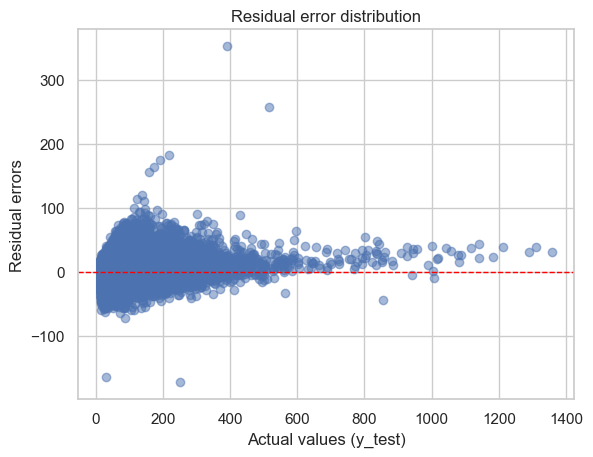

In [11]:
# calculate and visualize residual errors
residuals = y_test - y_pred_lr

plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Actual values (y_test)")
plt.ylabel("Residual errors")
plt.title("Residual error distribution")
plt.show()

The results for the initial Linear Regression model seem to be quite solid, with an R² of 0.96, suggesting that the model explains a large portion of the variability in the data. The MAE (7.71) and RMSE (10.88) are within a reasonable range depending on the scale of the arr_delay values.

Variables such as dep_delay, taxi_in, and taxi_out have the most significant positive impacts, as expected in a delay prediction problem. Some categories (e.g., time_category_evening, medium_haul, etc.) also show significant coefficients. We observe variables with large coefficients, such as unique_carrier_freq or origin_freq. These might require deeper analysis.

#### Elastic net

In [12]:
# Elastic Net
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train, y_train)
y_pred_en = elastic_net.predict(X_test)

In [13]:
# model evaluation
mae_en = mean_absolute_error(y_test, y_pred_en)
rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))
r2_en = r2_score(y_test, y_pred_en)

print("\nInitial Model Results - Elastic Net:")
print(f"MAE: {mae_en:.2f}")
print(f"RMSE: {rmse_en:.2f}")
print(f"R²: {r2_en:.2f}")


Initial Model Results - Elastic Net:
MAE: 7.96
RMSE: 11.08
R²: 0.96


In [14]:
# model coefficients
print("\nElastic Net Model Coefficients:")
for feature, coef in zip(X.columns, elastic_net.coef_):
    print(f"{feature}: {coef:.4f}")


Elastic Net Model Coefficients:
month: 0.0876
day: -0.0030
day_of_week: -0.0504
dep_time: -0.0008
crs_elapsed_time: -0.0283
dep_delay: 0.9698
taxi_in: 0.8742
taxi_out: 0.8703
tavg: -0.0000
prcp: 0.0379
snow: 0.0850
wspd: -0.1123
is_holiday: 0.0000
tomorrow_is_holiday: -0.0000
unique_carrier_freq: 1.3550
origin_freq: -0.0000
dest_freq: -0.0000
time_category_evening: -0.8663
time_category_morning: 0.0679
time_category_night: -0.0728
medium_haul: 0.5356
long_haul: 0.0000
ultra_long_haul: 0.0000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


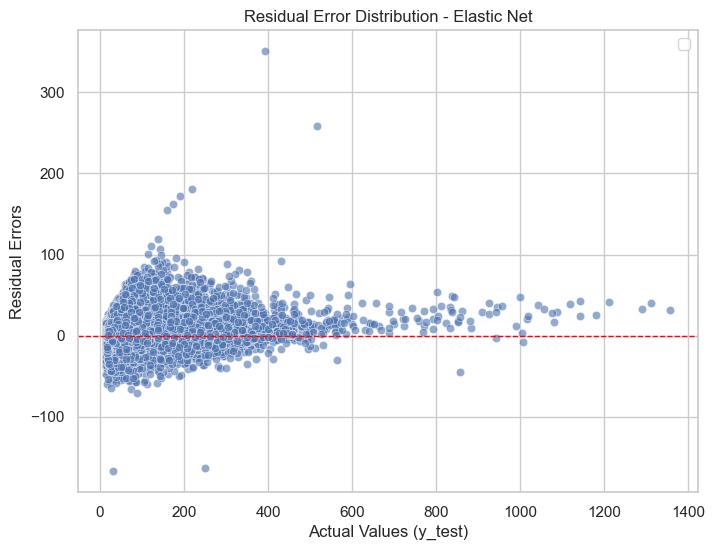

In [15]:
# distribution of residual errors
residuals = y_test - y_pred_en

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Error Distribution - Elastic Net")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Residual Errors")
plt.legend()
plt.show()

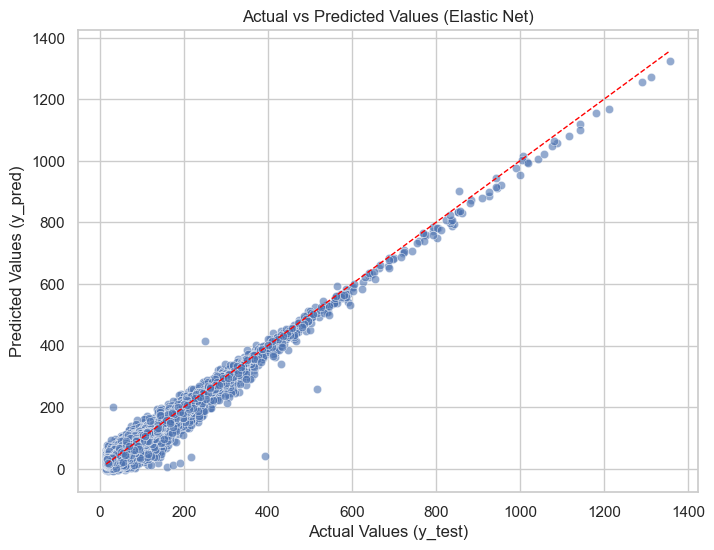

In [16]:
# results visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_en, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=1)
plt.title("Actual vs Predicted Values (Elastic Net)")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.show()

The Elastic Net model achieves strong performance with R²: 0.96, indicating it explains 96% of the variance in delays. Key predictors like dep_delay, taxi_in, and taxi_out show strong influence, while less relevant features (e.g., origin_freq) are effectively regularized. Residuals are mostly well-distributed, though some outliers suggest areas for improvement.

#### K-Nearest Neighbors (KNN)

In [17]:
# normalize data (for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# hyperparameter configuration for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]}

In [19]:
# create the model and search for the best hyperparameters
knn = KNeighborsRegressor()
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 10], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=1)

In [20]:
# results of the best model
best_knn = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}


In [21]:
# K-Nearest Neighbors (KNN)
knn_model = KNeighborsRegressor(n_neighbors=7, weights='distance', p=2)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

C:\Users\denis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\denis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [22]:
mae = mean_absolute_error(y_test, y_pred_knn)
mse = mean_squared_error(y_test, y_pred_knn)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_knn)

print("\nKNN results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


KNN results:
MAE: 13.13
RMSE: 18.33
R²: 0.90


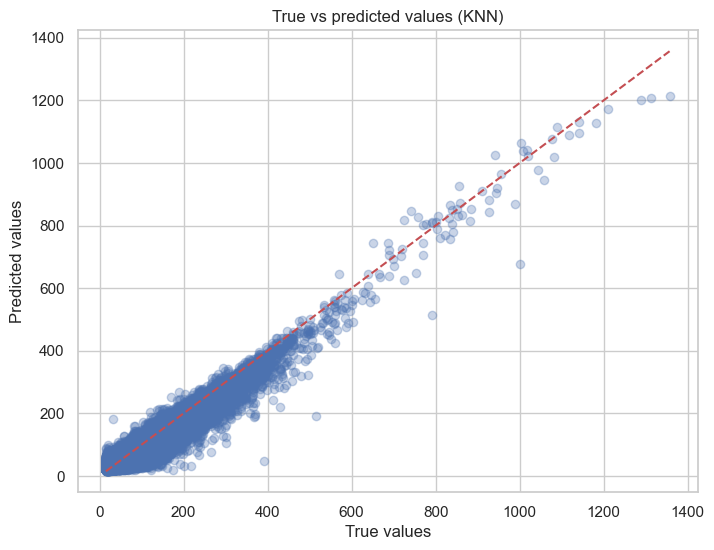

In [23]:
# results visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_knn, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect prediction')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True vs predicted values (KNN)")
plt.show()

The chart shows a high correlation between the actual values and the predicted values. The predictions closely align the reference line, including satisfactory performance.

#### Decision tress

In [24]:
# define the base model
dt_model = DecisionTreeRegressor(random_state = 42)

In [25]:
# define the hyperparameter range
param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']}
# configure hyperparameter search
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1)

In [26]:
# train the model
grid_search.fit(X_train, y_train)

# Get the best model
best_dt = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best hyperparameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [27]:
# predictions
y_pred_dt = best_dt.predict(X_test)

In [28]:
# evaluation metrics
mae = mean_absolute_error(y_test, y_pred_dt)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2 = r2_score(y_test, y_pred_dt)

print("\nDecision tree model results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Decision tree model results:
MAE: 7.84
RMSE: 11.11
R²: 0.96


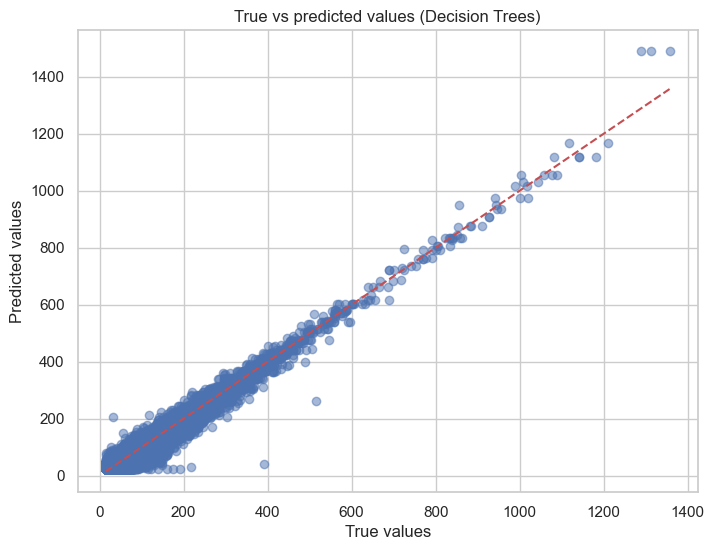

In [29]:
# results visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_dt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect prediction')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('True vs predicted values (Decision Trees)')
plt.show()

#### Comparison of Results - Initial Models

In [30]:
# comparison of results
models = ['Linear Regression', 'Elastic Net', 'KNN', 'Decision Trees']
predictions = [y_pred_lr, y_pred_en, y_pred_knn, y_pred_dt]

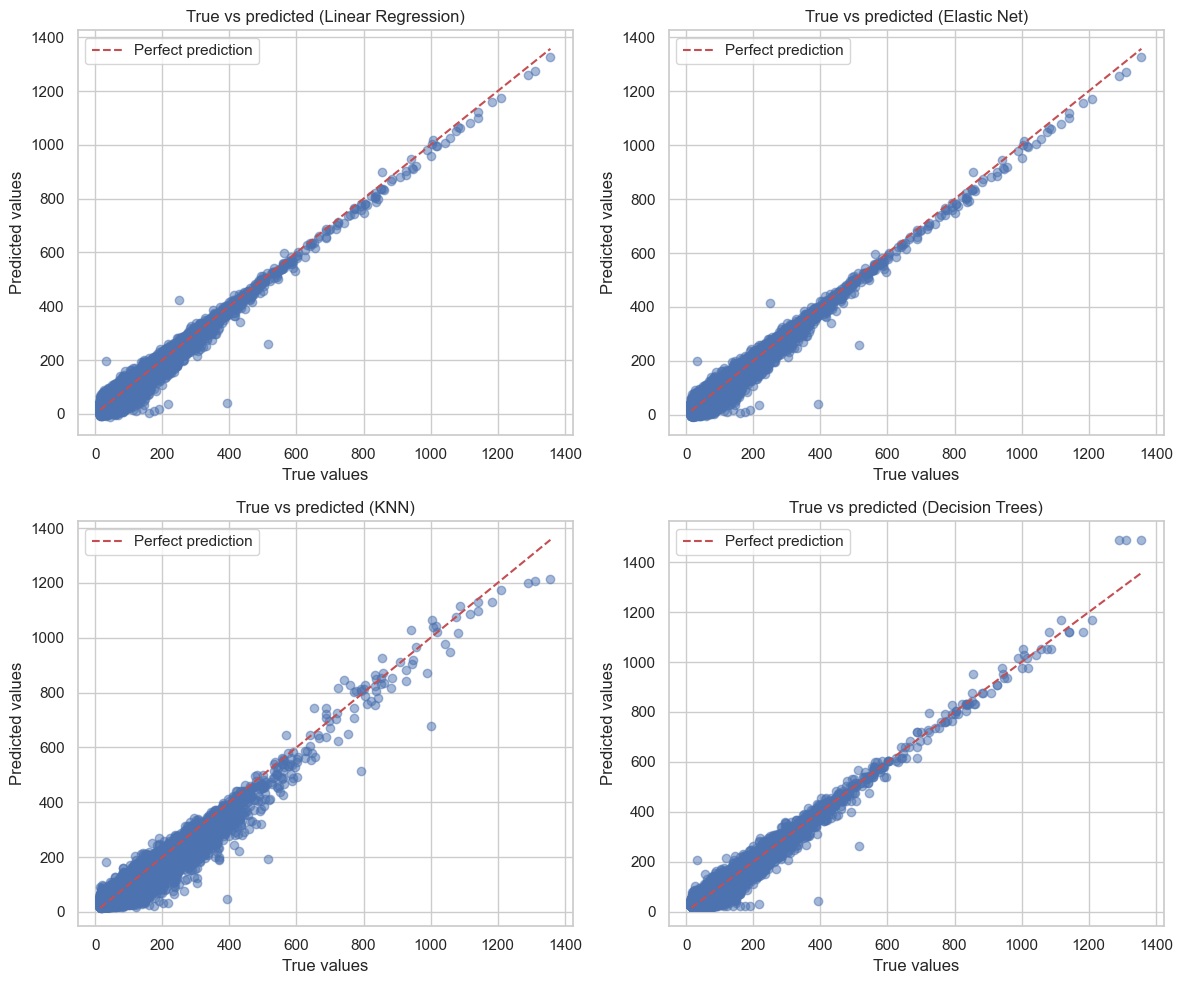

In [31]:
# plots to compare true vs predicted
plt.figure(figsize=(12, 10))
for i, (model, preds) in enumerate(zip(models, predictions)):
    plt.subplot(2, 2, i + 1)
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect prediction")
    plt.title(f"True vs predicted ({model})")
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.legend()
plt.tight_layout()
plt.show()

In [32]:
# metrics for each model
metrics = []
for model, preds in zip(models, predictions):
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = mse**0.5
    r2 = r2_score(y_test, preds)
    metrics.append([model, mae, rmse, r2])

metrics_df = pd.DataFrame(metrics, columns=['Model', 'MAE', 'RMSE', 'R²'])
print(metrics_df)

               Model        MAE       RMSE        R²
0  Linear Regression   7.710639  10.880258  0.963622
1        Elastic Net   7.960523  11.082391  0.962258
2                KNN  13.129695  18.327687  0.896777
3     Decision Trees   7.842744  11.113142  0.962048


The results above show that Linear Regression and Elastic Net are the best options among the initial models, with low errors (MAE and RMSE are close) and a high R², indicating strong predictive capability. Both are simple and effective models for this problem. On the other hand, KNN performs significantly worse, with higher errors and a lower R², suggesting it does not fit the data as well as the other models. Decision Trees deliver performance similar to the linear models, with competitive metrics, but they may have a tendency to overfit if not properly controlled.

The plots reinforce these findings, showing that the linear models closely follow the perfect prediction line, while KNN exhibits greater dispersion and errors. Although Decision Trees also align well with the line, their flexibility might lead to inconsistencies on other datasets.

### Advanced Models
We proceed with advanced models to capture complex relationships, improve accuracy, and address the limitations observed in baseline approaches for predicting the target variable (arr_delay).
- Random forest
- Gradient boosting (XGBoost)
- LightGBM

#### Random forest

In [33]:
# random forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [34]:
# metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Results:")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²: {r2_rf:.2f}")

Random Forest Results:
MAE: 6.95
RMSE: 10.01
R²: 0.97


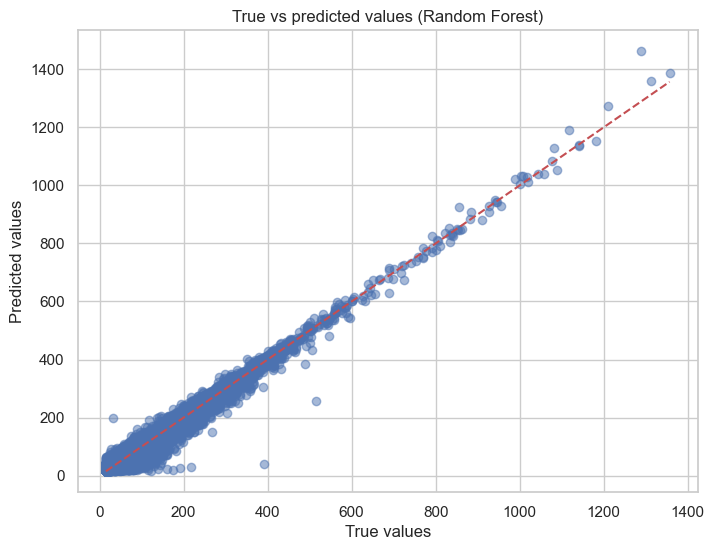

In [35]:
# results visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect prediction")
plt.title("True vs predicted values (Random Forest)")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

In [36]:
# hyperparameter optimization
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\denis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
6 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\denis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\denis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packa

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error', verbose=1)

In [37]:
# best model
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

In [38]:
# best model metrics
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = mse_best_rf ** 0.5
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("\nOptimized Random Forest Results:")
print(f"MAE: {mae_best_rf:.2f}")
print(f"RMSE: {rmse_best_rf:.2f}")
print(f"R²: {r2_best_rf:.2f}")


Optimized Random Forest Results:
MAE: 6.88
RMSE: 9.95
R²: 0.97


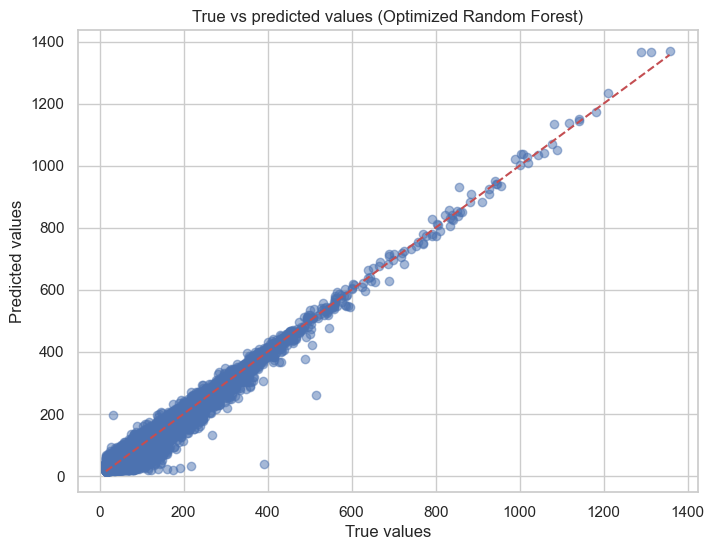

In [39]:
# results visualization for best model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect prediction")
plt.title("True vs predicted values (Optimized Random Forest)")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

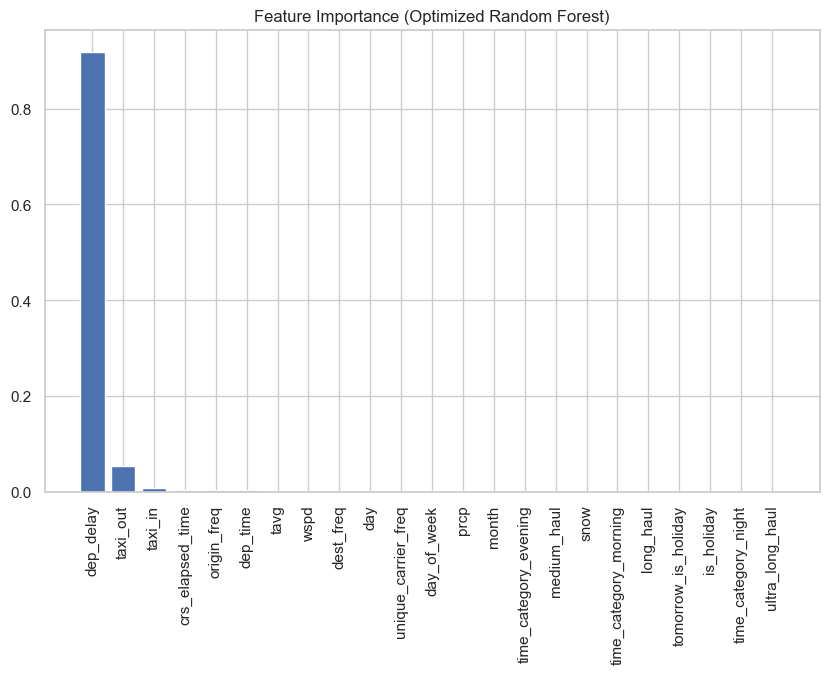

In [40]:
# feature importance
importances = best_rf.feature_importances_
sorted_indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[sorted_indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.title("Feature Importance (Optimized Random Forest)")
plt.show()

In [41]:
# permutation importance
perm_importance_rf = permutation_importance(
    estimator=best_rf,
    X=X_test,
    y=y_test,
    scoring='neg_mean_absolute_error',
    n_repeats=5,
    random_state=42,
    n_jobs=1)

In [42]:
# create a df to sort features by importance
perm_df_rf = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance_rf.importances_mean,
    'Std Dev': perm_importance_rf.importances_std
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Importance Results:")
print(perm_df_rf)


Permutation Importance Results:
                  Feature  Importance   Std Dev
5               dep_delay   41.487098  0.044952
7                taxi_out    6.626733  0.015291
6                 taxi_in    1.073275  0.007373
4        crs_elapsed_time    0.561858  0.004114
15            origin_freq    0.432419  0.004055
14    unique_carrier_freq    0.193650  0.002087
16              dest_freq    0.125555  0.000840
3                dep_time    0.050229  0.001729
8                    tavg    0.028664  0.000993
1                     day    0.020027  0.001184
0                   month    0.016068  0.000657
11                   wspd    0.015533  0.001244
17  time_category_evening    0.010205  0.000691
9                    prcp    0.005096  0.000461
2             day_of_week    0.003649  0.000671
20            medium_haul    0.002188  0.000238
18  time_category_morning    0.000765  0.000278
21              long_haul    0.000685  0.000150
19    time_category_night    0.000493  0.000080
10     

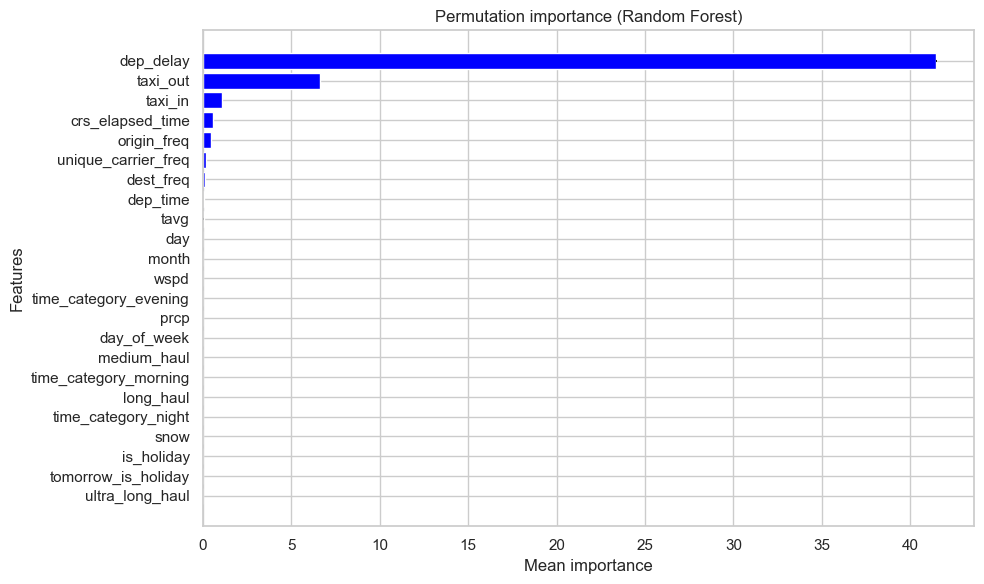

In [43]:
# Permutation Importance visualization
plt.figure(figsize=(10, 6))
plt.barh(perm_df_rf['Feature'], perm_df_rf['Importance'], xerr=perm_df_rf['Std Dev'], color='blue')
plt.gca().invert_yaxis()
plt.title("Permutation importance (Random Forest)")
plt.xlabel("Mean importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

The first random forest already demonstrates strong performance with an MAE of 6.95, RMSE of 10.01, and an R² of 0.97. Meanwhile, the optimized version slightly improves these results: MAE of 6.88, RMSE of 9.95, while maintaining an R² of 0.97.

The true vs predicted plots show that both models closely align with the perfect prediction line, indicating a solid fit.

Regarding the feature importance analysis, it reveals that the variable dep_delay overwhelmingly dominates the predictions, with minor contributions from variables like taxi_out and taxi_in.

This dominance suggests that if a flight departs late, it is highly likely to arrive late unless time is recovered en route. departure_delay captures a significant part of this relationship.

In operational scenarios, such as airline management systems, departure_delay is real-time information that can be useful for predicting arrival_delay.

#### Gradient boosting (XGBoost)

In [44]:
# XGBoost model
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

In [45]:
# model parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 6,
    'colsample_bytree': 0.8,
    'seed': 42}

In [46]:
# cross-validation using XGBoost
cv_results = xgb.cv(
    dtrain=train_dmatrix,
    params=params,
    nfold=5,
    num_boost_round=100,
    metrics="mae",
    as_pandas=True,
    seed=42
)

print(cv_results)
print("\nBest MAE during CV:", cv_results['test-mae-mean'].min())

    train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0        37.833719       0.028023      37.836854      0.036578
1        34.494680       0.025967      34.499004      0.030140
2        31.330778       0.023668      31.335419      0.027257
3        28.673290       0.021910      28.679108      0.023244
4        26.135676       0.019559      26.143974      0.021832
..             ...            ...            ...           ...
95        6.822868       0.015481       6.985116      0.040059
96        6.816572       0.014597       6.979690      0.040597
97        6.811694       0.015057       6.975575      0.039717
98        6.807295       0.014763       6.971971      0.039652
99        6.802564       0.014634       6.968286      0.040005

[100 rows x 4 columns]

Best MAE during CV: 6.96828613623197


In [47]:
# train the model
xgb_model = xgb.train(params=params, dtrain=train_dmatrix,num_boost_round=100)
y_pred_xgb = xgb_model.predict(test_dmatrix)

In [48]:
# metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Results:")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²: {r2_xgb:.2f}")


XGBoost Results:
MAE: 7.05
RMSE: 12.18
R²: 0.95


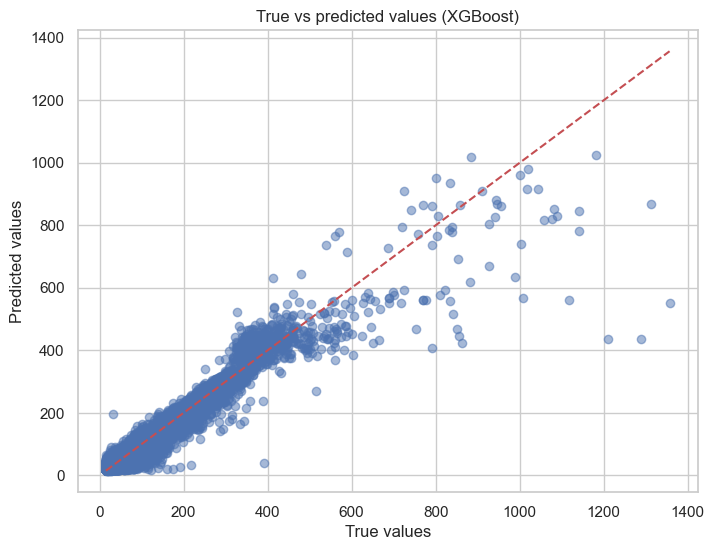

In [49]:
# results visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect prediction")
plt.title("True vs predicted values (XGBoost)")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

The XGBoost model has demonstrated strong performance with an MAE of 7.05 and an R² of 0.95 indicating high predictive capability. However, the RMSE of 12.18 suggests that some large errors still impact the model.

Cross-validation confirms its stability, with a best MAE of 6.97. While it handles most values well there is some dispersion in higher predictions, which may require additional hyperparameter tuning or a deeper analysis of outliers.

Compared to previous models, it offers a balance between accuracy and robustness, making it a strong option for complex regression problems.

#### LightGBM

In [50]:
# LGBMRegressor
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', random_state=42, n_estimators=100, learning_rate=0.1)

In [51]:
# train the model
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[ early_stopping(stopping_rounds=10), log_evaluation(10)])
y_pred_lgb = lgb_model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data points in the train set: 339184, number of used features: 23
[LightGBM] [Info] Start training from score 60.896802
Training until validation scores don't improve for 10 rounds
[10]	valid_0's l2: 541.557
[20]	valid_0's l2: 186.12
[30]	valid_0's l2: 129.622
[40]	valid_0's l2: 115.54
[50]	valid_0's l2: 109.61
[60]	valid_0's l2: 106.076
[70]	valid_0's l2: 103.56
[80]	valid_0's l2: 101.537
[90]	valid_0's l2: 99.7717
[100]	valid_0's l2: 98.5385
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 98.5385


In [52]:
# metrics
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = mean_squared_error(y_test, y_pred_lgb) ** 0.5
r2_lgb = r2_score(y_test, y_pred_lgb)

print("\nInitial LightGBM Results:")
print(f"MAE: {mae_lgb:.2f}")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"R²: {r2_lgb:.2f}")


Initial LightGBM Results:
MAE: 6.68
RMSE: 9.93
R²: 0.97


In [53]:
# hyperparameter optimization
param_grid = {'num_leaves': [20, 31, 50], 'max_depth': [10, 15, -1], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300],}

In [54]:
# GridSearchCV for optimization
grid_search = GridSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data points in the train set: 339184, number of used features: 23
[LightGBM] [Info] Start training from score 60.896802


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [10, 15, -1],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [20, 31, 50]},
             scoring='neg_mean_absolute_error', verbose=1)

In [55]:
# best model
best_lgb = grid_search.best_estimator_
y_pred_best_lgb = best_lgb.predict(X_test)

In [56]:
# best model metrics
mae_best_lgb = mean_absolute_error(y_test, y_pred_best_lgb)
mse_best_lgb = mean_squared_error(y_test, y_pred_best_lgb)
rmse_best_lgb = mse_best_lgb**0.5
r2_best_lgb = r2_score(y_test, y_pred_best_lgb)

print("\nOptimized LightGBM Results:")
print(f"MAE: {mae_best_lgb:.2f}")
print(f"RMSE: {rmse_best_lgb:.2f}")
print(f"R²: {r2_best_lgb:.2f}")


Optimized LightGBM Results:
MAE: 6.22
RMSE: 9.35
R²: 0.97


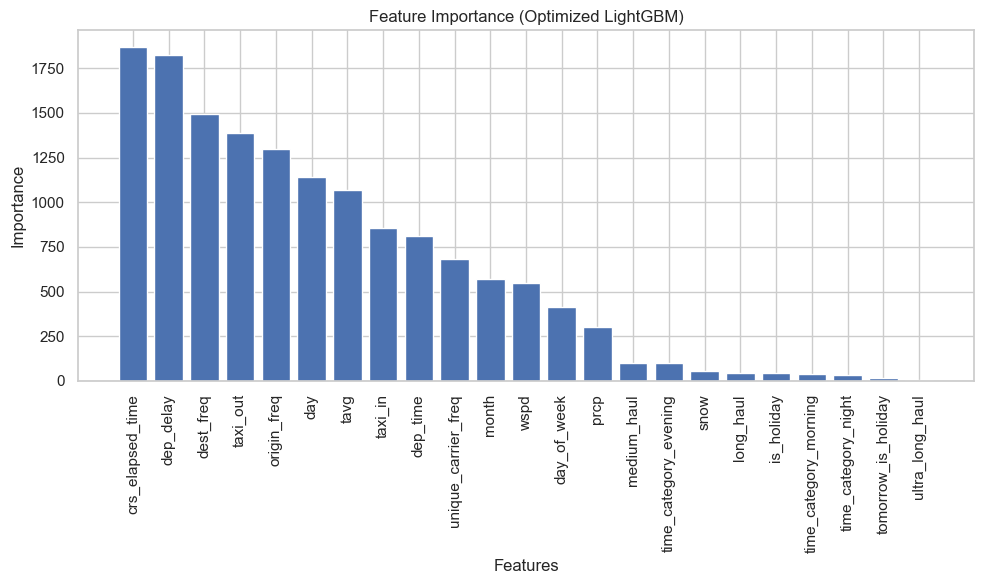

In [57]:
# feature importance
feature_importance = best_lgb.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.title("Feature Importance (Optimized LightGBM)")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [58]:
# permutation importance
perm_importance_lgb = permutation_importance(
    estimator=best_lgb,
    X=X_test,
    y=y_test,
    scoring='neg_mean_absolute_error',
    n_repeats=5,
    random_state=42,
    n_jobs=1)

In [59]:
# create a df to sort features by importance
perm_df_lgb = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance_lgb.importances_mean,
    'Std Dev': perm_importance_lgb.importances_std
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Importance Results:")
print(perm_df_lgb)


Permutation Importance Results:
                  Feature  Importance   Std Dev
5               dep_delay   42.289577  0.038662
7                taxi_out    7.554588  0.017810
6                 taxi_in    1.491299  0.006127
4        crs_elapsed_time    0.917396  0.006901
15            origin_freq    0.794668  0.002967
16              dest_freq    0.624389  0.002517
14    unique_carrier_freq    0.358293  0.001808
1                     day    0.184750  0.003625
20            medium_haul    0.165273  0.002098
0                   month    0.150029  0.003723
8                    tavg    0.148054  0.001753
2             day_of_week    0.087106  0.001220
3                dep_time    0.081036  0.001053
17  time_category_evening    0.066554  0.001968
21              long_haul    0.049914  0.002162
11                   wspd    0.038108  0.001191
9                    prcp    0.021362  0.001132
12             is_holiday    0.006385  0.000286
18  time_category_morning    0.005886  0.000544
10     

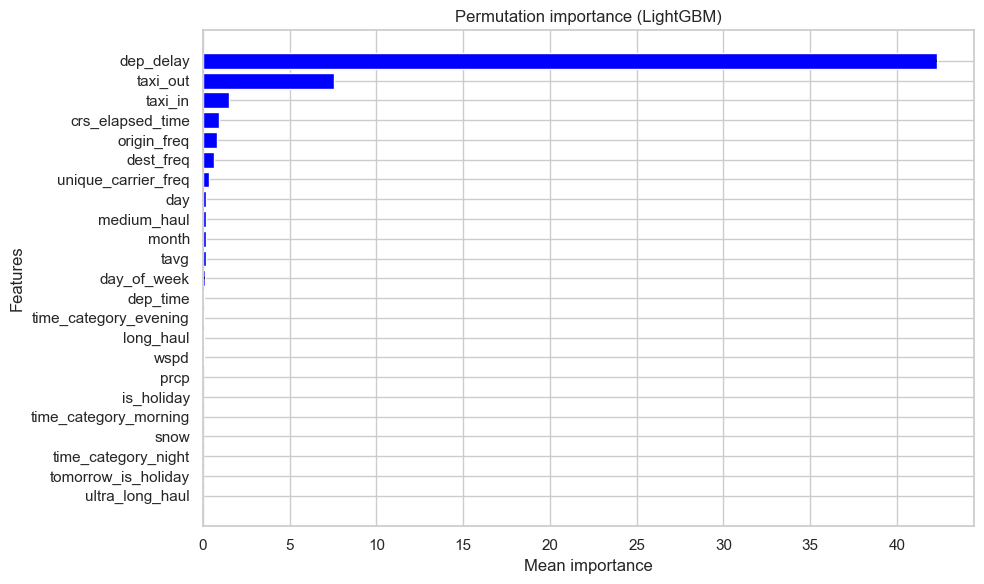

In [60]:
# Permutation Importance visualization
plt.figure(figsize=(10, 6))
plt.barh(perm_df_lgb['Feature'], perm_df_lgb['Importance'], xerr=perm_df_lgb['Std Dev'], color='blue')
plt.gca().invert_yaxis()
plt.title("Permutation importance (LightGBM)")
plt.xlabel("Mean importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

The LightGBM model has proven to be one of the most accurate options for delay prediction, outperforming other advanced models in terms of performance. With an MAE of 6.22 and an RMSE of 9.35, it demonstrates its ability to capture complex patterns in the data. The R² of 0.97 confirms that it explains the majority of the variability in the data.

Furthermore, the most important features, such as dep_delay, taxi_out, and crs_elapsed_time, highlight key operational factors in the prediction process.

This model offers a strong balance between accuracy and efficiency, making it suitable for implementation in practical scenarios.

#### Comparison of results - Advanced models

In [61]:
# comparison of results
models_advanced = ['Random Forest', 'XGBoost', 'LightGBM']
predictions_advanced = [y_pred_best_rf, y_pred_xgb, y_pred_best_lgb]

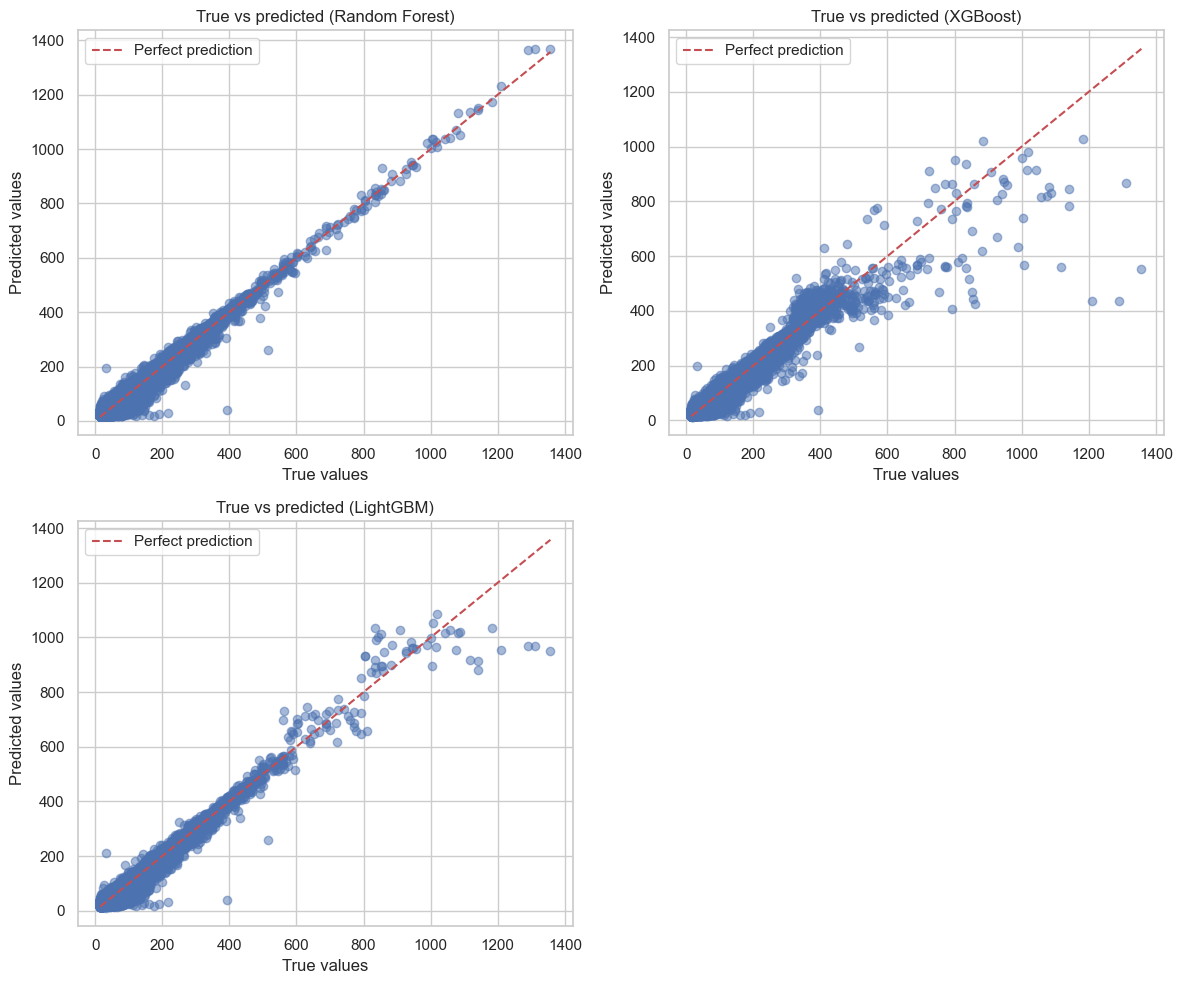

In [62]:
# plots to compare true vs predicted
plt.figure(figsize=(12, 10))
for i, (model, preds) in enumerate(zip(models_advanced, predictions_advanced)):
    plt.subplot(2, 2, i + 1)
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect prediction")
    plt.title(f"True vs predicted ({model})")
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.legend()
plt.tight_layout()
plt.show()

In [63]:
# metrics for each model
metrics_advanced = []
for model, preds in zip(models_advanced, predictions_advanced):
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = mse**0.5
    r2 = r2_score(y_test, preds)
    metrics_advanced.append([model, mae, rmse, r2])

metrics_advanced_df = pd.DataFrame(metrics_advanced, columns=['Model', 'MAE', 'RMSE', 'R²'])
print(metrics_advanced_df)

           Model       MAE       RMSE        R²
0  Random Forest  6.878192   9.949890  0.969577
1        XGBoost  7.045541  12.178298  0.954424
2       LightGBM  6.216691   9.349747  0.973137


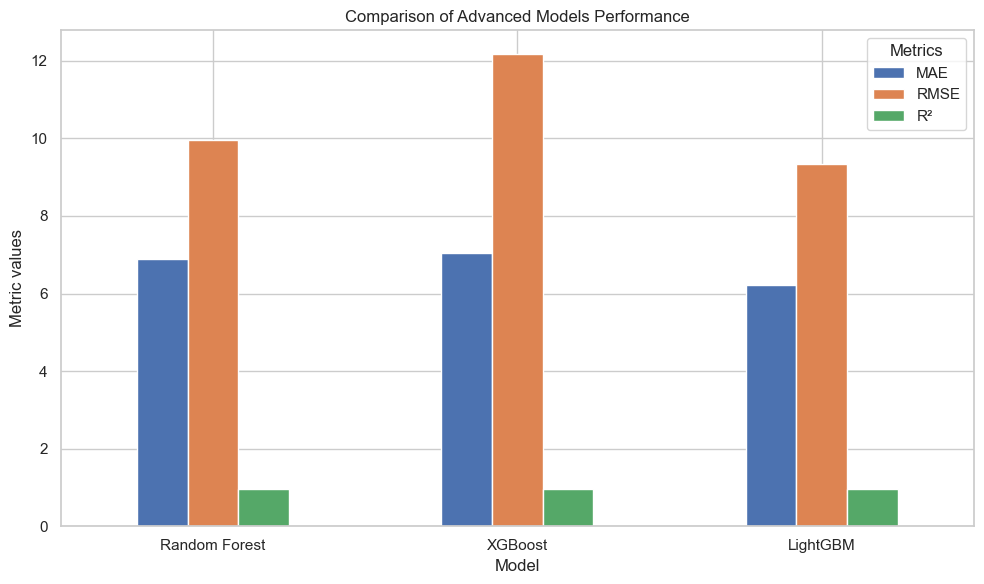

In [64]:
# plot metrics for better comparison
metrics_advanced_df.set_index('Model', inplace=True)
metrics_advanced_df.plot(kind='bar', figsize=(10, 6))
plt.title("Comparison of Advanced Models Performance")
plt.ylabel("Metric values")
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

LightGBM is, without a doubt, the most accurate model among the afvanced models. It achieves the lowest Mean Absolute Error and Root Mean Squared Error , along with the highest R² in the set. This indicates that LightGBM captures the dataset’s variations with greater precision and produces predictions closer to the actual values.

Random Forest, while slightly less accurate than LightGBM, delivers consistent results with an MAE of 6.88 and an RMSE of 9.95. Its R² keeps it competitive, and its simplicity of interpretation, combined with its ability to handle non-linear and heterogeneous data, makes it a solid choice, particularly if a more interpretable model is preferred.

XGBoost, on the other hand, demonstrates the weakest performance among the three advanced models. Its MAE and RMSE are significantly higher, and its R² indicates it explains less variability in the data. While XGBoost is often a top-performing model in many contexts, in this case, it appears less suited to the dataset or may require more extensive hyperparameter tuning.

In terms of visualization, the true vs predicted plots confirm that LightGBM and Random Forest have a higher concentration of points near the perfect prediction line, whereas XGBoost exhibits greater dispersion, reflecting its higher error.